In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

#to see full text:
pd.set_option("display.max_colwidth", -1)

print(colored("\nNECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["bold", "dark"]))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



NECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [2]:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding = "ISO-8859-1", engine = "python")

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...",  color = "green", attrs = ["bold", "dark"]))


DATASETS WERE SUCCESFULLY LOADED...


### <span style = "background:#410F01; border:black solid; font-size:100%; color:#fff; border-radius:10px;">Look at the dataset</span>

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [4]:
#rename dataset columns
data.rename(columns = {"v1": "target", "v2": "text"}, inplace = True)

#drop unnecessary columns
data.drop(["Unnamed: 2","Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)

print(colored("\nOPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...",  color = "green", attrs = ["bold", "dark"]))


OPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...


In [5]:
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
data.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
print(colored("There are {} duplicated values in the dataset".format(data.duplicated().sum()), color = "green", attrs = ["bold", "dark"]))

There are 403 duplicated values in the dataset


In [8]:
data.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", color = "green", attrs = ["bold", "dark"]))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [9]:
grouped_target = data.groupby("target").count()
grouped_target["text"]

target
ham     4516
spam    653 
Name: text, dtype: int64

In [10]:
data.isnull().sum()

target    0
text      0
dtype: int64

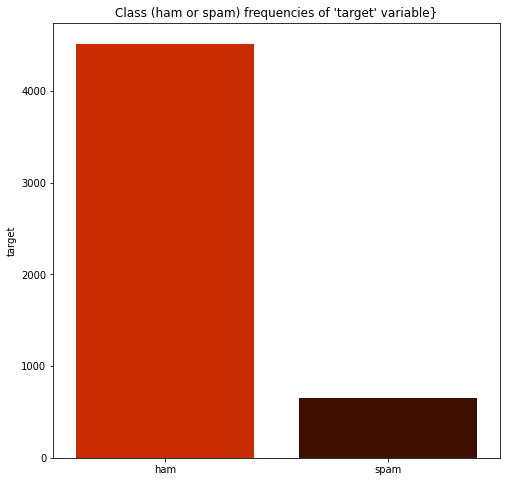

In [11]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "white")

sns.barplot(x = data["target"].value_counts().index,
            y = data["target"].value_counts(), palette = ["#C82C02", "#410F01"],
            saturation = 1).set(title = "Class (ham or spam) frequencies of 'target' variable}");

In [12]:
fig = px.pie(data_frame = data, names = "target", hole = 0.4, title = "counts in 'target' variable", 
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.5, color = "#410F01")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

In [13]:
data["ch_no"] = data["text"].apply(len)
data["wd_no"] = data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data["sn_no"] = data.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

data.describe().T.style.background_gradient(cmap = "Purples_r")

,count,mean,std,min,25%,50%,75%,max
ch_no,5169.000000,78.977945,58.236293,2.000000,36.000000,60.000000,117.000000,910.000000
wd_no,5169.000000,18.453279,13.324793,1.000000,9.000000,15.000000,26.000000,220.000000
sn_no,5169.000000,1.947185,1.362406,1.000000,1.000000,1.000000,2.000000,28.000000


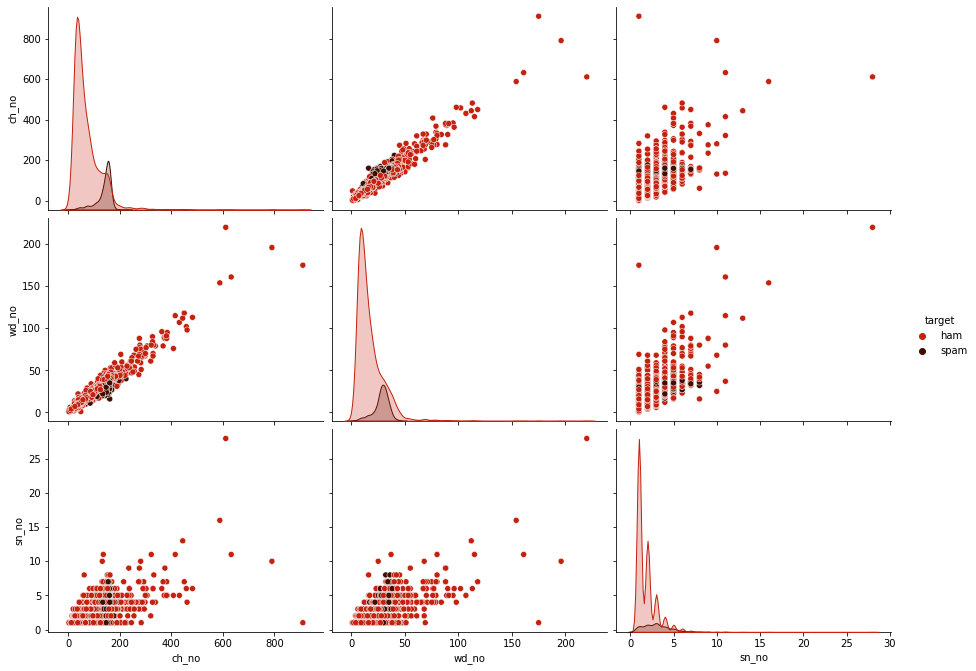

In [14]:
fig = sns.pairplot(data = data, hue = "target", palette = ["#C4210E", "#410F01"], height = 3.15, aspect = 1.35)
plt.show(fig);

In [15]:
data["text"] = data["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nUPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...", color = "green", attrs = ["bold", "dark"]))


UPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...


In [16]:
data["text"] = data["text"].str.replace('[^\w\s]','')

print(colored("\nPUNCTUATION MARKS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))


PUNCTUATION MARKS WERE SUCCESFULLY DELETED...


In [17]:
data["text"] = data["text"].str.replace('\d','')

print(colored("\nNUMBERS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))


NUMBERS WERE SUCCESFULLY DELETED...


In [18]:
stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

data["text"] = data["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

print(colored("\nSTOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...", color = "green", attrs = ["bold", "dark"]))


STOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...


In [19]:
data["text"] = data["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nTEXTS WERE SUCCESFULLY LEMMATIZED...", color = "green", attrs = ["bold", "dark"]))


**********************************************************************
  Resource omw-1.4 not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('omw-1.4')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/omw-1.4

  Searched in:
    - '/root/nltk_data'
    - '/opt/conda/nltk_data'
    - '/opt/conda/share/nltk_data'
    - '/opt/conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


In [ ]:
data["text"] = data["text"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

print(colored("\nURLs WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))

In [ ]:
data["text"] = data["text"].apply(lambda x: ' '.join([x for x in x.split() if len(x) > 3]))

print(colored("\nWORDS LESS THAN 3 LETTERS LONG WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))

In [ ]:
data.head(n = 10)

In [ ]:
corpus = []
for i in data.text:
    for j in i.split():
        corpus.append(j.strip())

In [ ]:
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

In [ ]:
text = " ".join(i for i in data.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

In [ ]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "spam"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'spam'");

In [ ]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "ham"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'ham'");

In [ ]:
lb = LabelEncoder()
data["target"] = lb.fit_transform(data["target"])

In [ ]:
x = data["text"]
y = data["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDATASET WAS SUCCESFULLY DIVIDED ...", color = "green", attrs = ["bold", "dark"]))

In [ ]:
print("The shape of 'train_x' is {} and the shape of 'test_x' is {}".format(train_x.shape[0], test_x.shape[0]))

In [ ]:
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(tokenized_train, maxlen = None)
test_x = sequence.pad_sequences(tokenized_test, maxlen = None)

In [ ]:
GLOVE_EMBEDDING = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

#_________________________________________________________________________________________#

#_________________________________________________________________________________________#

embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(6012, len(word_index))+1

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 6012:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [ ]:
model = Sequential()

model.add(Embedding(6013, output_dim = 100, weights = [embedding_matrix], trainable = False))

model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5))

model.add(LSTM(units = 64, recurrent_dropout = 0.3, dropout = 0.5))

model.add(Dense(units = 32, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01), loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 64,
                    validation_data = (test_x, test_y),
                    epochs = 20,
                    callbacks = [lr_reduce])

In [ ]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

In [ ]:
epochs = [i for i in range(20)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

In [ ]:
conf_mat = confusion_matrix(test_y, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()